# Masked Autoencoder for Distribution Estimation (MADE)

The method is proposed by paper https://arxiv.org/abs/1502.03509

**Task**: design neural network models to estimate a distribution

**Challenge:** curse of dimensionality

**Autoregressive constraints**: each input is reconstructed only from previous inputs in a given order. 

$$p(\mathbf{x}) = p(x_1)p(x_2|x_1)p(x_3|x_1,x_2)\cdots = \prod_{d=1}^D p(x_d|\mathbf{x}_{<d})$$



**Question**: How (to use neural networks to estimate a distribution through MADE)? 

* Base model: Autoencoder Neural Network

* Input $(x_1, x_2,..,x_D) \rightarrow$ Output $\hat{x}_d = p(x_d|\mathbf{x}_{x<d})$ 

* Mask weighted connections such that the output is autoregressive for a given ordering of the inputs. Specifically,

$$\text{Any Layer $l$:  } M_{k',k}^{W^l} = \mathbb{1}_{m^l(k')\ge m^{l-1}(k)} $$
$$\text{Last Layer:  } M_{d,k}^{V} = \mathbb{1}_{d> m^L(k)}$$

* Loss function: negative log-likelihood:

$$l(\mathbf{x}) = -\log p(\mathbf{x}) = \sum_{d=1}^D - \log p(x_d|\mathbf{x}_{<d})$$

* Order/Connectivity agnostic: random sampling

$$\mathbf{m}^0 = \text{shuffle}([1,...,D]), m^l(k) = \text{Unif}([\min_{k'} m^{l-1}(k'),..,D-1])$$



# Applications of TFP for regression with uncertainty

This section re-implements the ideas in https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html

* Specify a probabilistic model and minimize the negative log-likelihood

* Deal with aleatoric uncertainty or/and epistemic uncertainty


> 1.   Aleatoric uncertainty: variablity in y for any particular value of x (the uncertainty that has a known functional relationship with x)
2.  Epistemic uncertainty: variablity in the estimated parameters of the model 






In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
# Generate data

k = 1
b = 5
x_min = -50
x_max = 50
n = 150

def aleatoric(x): # variablity function for a particular x
  r = (x - x_min) / (x_max - x_min)
  return 2 * r

def generate_data(n):
  x = (x_max - x_min) * np.random.rand(n) + x_min 
  noise = np.random.randn(n) * aleatoric(x)
  y = (k * x * (1 + np.sin(x)) + b) + noise   # add some non-linearity and noise
  x = x[..., np.newaxis] # convert to N * 1 matrix
  return x, y

x_train, y_train = generate_data(n)
x_test, y_test = generate_data(n)

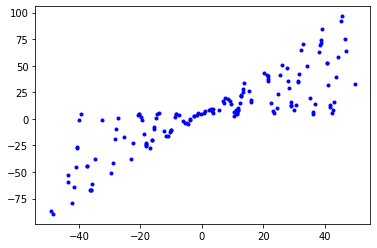

In [3]:
# Plot data

plt.figure()
plt.plot(x_train, y_train, "b.")

In [4]:
# Loss function

def negloglik(y, py):
  return - py.log_prob(y)

## Model 1: No uncertainty 

In [8]:
# Using a DistributionLambda layer to output a (normal) distribution
# where the mean is outputed by the second last layer
# x -> mean -> Normal(mean, 3)

model1 = tf.keras.Sequential([
                             tf.keras.layers.Dense(1), # approximate mean only: mean = kx (linear)
                                                      # N * 1 -> N * 1 
                             tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=3)) # constant variance
])                                                                                    
model1.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model1.fit(x_train,y_train, epochs=1000, verbose=False)

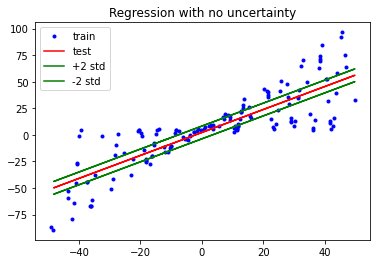

In [29]:
pred_m = model1(x_test).mean()
pred_std = model1(x_test).stddev()  # should be constant
pred_ub = pred_m + 2 * pred_std     # upper bound
pred_lb = pred_m - 2 * pred_std     # lower bound

plt.figure()
plt.plot(x_train, y_train, 'b.', label="train")
plt.plot(x_test, pred_m, "r", label = "test")
plt.plot(x_test, pred_ub, "g", label = "+2 std")
plt.plot(x_test, pred_lb, "g", label = "-2 std")
plt.title("Regression with no uncertainty")
plt.legend()
plt.show()

Obviously, the model can not address the variability for different inputs appropritely. 

## Model 2: Aleatoric uncertainty only

In [31]:
model2 = tf.keras.Sequential([
                             tf.keras.layers.Dense(2),  # approximate both mean and variance
                                                        # mean = k1 x, std = k2 x (both linear)
                                                        # N * 1 -> N * 2 
                             tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:,:1], 
                                                                                scale=t[:,1:]))
])
model2.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model2.fit(x_train,y_train, epochs=1000, verbose=False)

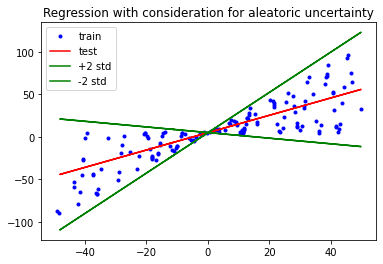

In [70]:
pred_m = model2(x_test).mean()
pred_std = model2(x_test).stddev() 
pred_ub = pred_m + 2 * pred_std     # upper bound
pred_lb = pred_m - 2 * pred_std     # lower bound

plt.figure()
plt.plot(x_train, y_train, 'b.', label="train")
plt.plot(x_test, pred_m, "r", label = "test")
plt.plot(x_test, pred_ub, "g", label = "+2 std")
plt.plot(x_test, pred_lb, "g", label = "-2 std")
plt.title("Regression with consideration for aleatoric uncertainty")
plt.legend()
plt.show()

Model 2 can capture the variablity in y for any particular x.

## Model 3: Epistemic uncertainty only

* Assume model parameter $\theta \sim $ Prior

* Approach: use a DenseVariational layer instead of a fixed Dense layer.

In [61]:
# Make posterior/prior function

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=0.2 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [62]:
model3 = tf.keras.Sequential([
                             tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x_train.shape[0]), 
                             tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:,:1], 
                                                                                scale=3)) # constant variance
])
model3.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model3.fit(x_train,y_train, epochs=1000, verbose=False)

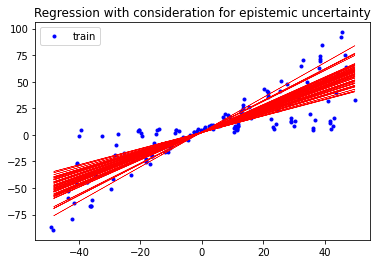

In [63]:
plt.figure()
plt.plot(x_train, y_train, 'b.', label="train")
for i in range(50):
  pred = model3(x_test)
  plt.plot(x_test, pred.mean(), 'r', linewidth=0.5)
plt.title("Regression with consideration for epistemic uncertainty")
plt.legend()
plt.show()

Model 3 can capture the variablity of the estimated parameters of the proposed model.

## Model 4: Both aleatoric and epistemic uncertainty

Combine the approaches in model 2 and model 3: 

* Estimate both the mean $\theta$ and standard error $\sigma$ using a 2-dimensonal dense layer

* Use the DenseVariational layer instead of the fixed Dense layer to capture the variablity of the estimated parameters.


In [65]:
model4 = tf.keras.Sequential([
                             tfp.layers.DenseVariational(2, posterior_mean_field, prior_trainable, kl_weight=1/x_train.shape[0]), 
                             tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:,:1], 
                                                                                scale=t[:,1:]))
])
model4.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model4.fit(x_train,y_train, epochs=1000, verbose=False)

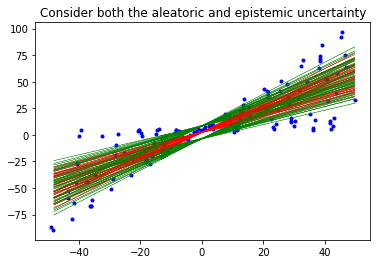

In [71]:
plt.figure()
plt.plot(x_train, y_train, 'b.', label="train")
for i in range(30):
  pred = model3(x_test)
  pred_m = pred.mean()
  pred_std = pred.stddev()
  plt.plot(x_test, pred_m, "r", label = "test", linewidth=0.3)
  plt.plot(x_test, pred_m + 2*pred_std, "g", label = "+2 std", linewidth=0.3)
  plt.plot(x_test, pred_m - 2*pred_std, "g", label = "-2 std", linewidth=0.3)
plt.title("Consider both the aleatoric and epistemic uncertainty")
plt.show()

Can get an ensemble mean and an ensemble variance of y for each value of x

# Concerns and next step


* It seems that the blog just uses NN to estimate the parameters of a proposed model, which does not apply MADE at all.

* Not fully understand how the DenseVariational layer works. Specifically, the make_posterior_fn and the make_prior_fn. Need to review Appendix B in the blog.

To do next:

* Understand Gaussian Process and how to use it to estimate y=f(x) under no model assumption (except the smoothness). 

* Need a big picture of how MADE, MAF, IAF contribute to Normalizing Flows. Not able to connect all the concepts till now together and need to get more insight for what we are doing. 

* Need more exploration in MAF and the autoregressive network in TFP, which will be reported next time. 

# Other References 

* https://www.youtube.com/watch?v=7q4ueFiJjAY
